In [1]:
import os
!git clone https://github.com/akxe449/Captcha_codebase.git


Cloning into 'Captcha_codebase'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 4), reused 3 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.38 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
# generating dataset for task 0
import os, random, re
from PIL import Image, ImageDraw, ImageFont
import nltk

# download nltk words
nltk.download("words")
from nltk.corpus import words as nltk_words

# no spaces b/w words
word_list = [w for w in nltk_words.words() if w.isalpha()]

# 100 capitalized words
sampled_words = [w.capitalize() for w in random.sample(word_list, 100)]

os.makedirs("easy_set_nltk", exist_ok=True)

font_size = 40
# this was the only compatible font, asked gemini
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", font_size)
    print(f"Using LiberationSans font, size {font_size}")
except IOError:
    print("Font path not found.. switching to default")
    font = ImageFont.load_default()

labels = []

# synthesis
for word in sampled_words:
# was having difficulty mapping images<->labels. hence stripped off the problem of naming
    safe_word = re.sub(r'[^A-Za-z0-9]', '', word)

# make fresh image
    img_w, img_h = 400, 80
    img = Image.new("RGB", (img_w, img_h), "white")
    draw = ImageDraw.Draw(img)

# moved from random coords to centre alignment (these commands center it)
    bbox = draw.textbbox((0, 0), word, font=font)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    x = (img_w - text_w) // 2
    y = (img_h - text_h) // 2

    draw.text((x, y), word, font=font, fill="black")

# word<->filename to avoid confusion
    fname = f"{safe_word}.png"
    img.save(os.path.join("easy_set_nltk", fname))

    labels.append(f"{fname},{word}")

#testing rendering
with open("easy_set_nltk/labels.csv", "w") as f:
    f.write("\n".join(labels))

print("Dataset loaded with", len(sampled_words), "images:)")




[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Using LiberationSans font, size 40
Dataset loaded with 100 images:)


In [3]:
#generating hard dataset

import numpy as np
from PIL import ImageFilter


output_dir = "hard_dataset"
font_retrieval = "/content/Captcha_codebase/fonts"
num_images = 100
image_size = (256, 64)

os.makedirs(output_dir, exist_ok=True)


# retrieve fonts from github
if not os.path.exists(font_retrieval):
    raise FileNotFoundError(f"Font folder not found: {font_retrieval}.did you clone properly?")

font_files = [os.path.join(font_retrieval, f) for f in os.listdir(font_retrieval) if f.endswith(".ttf")]

if not font_files:
    raise RuntimeError(f"No .ttf font files found in {font_retrieval}.")
else:
    print(f"Loaded {len(font_files)} fonts from {font_retrieval}:)")


labels = []
#adding noise now, asked gemini for better tweaks
def add_noise(img, noise_level=25):
    """Add pixel noise to background."""
    arr = np.array(img)
    noise = np.random.randint(-noise_level, noise_level, arr.shape, dtype=np.int16)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def generate_image(word, file_path):
#randomising
    font_file = random.choice(font_files)
    font_size = random.randint(28, 40)
    try:
        font = ImageFont.truetype(font_file, font_size)
    except:
        font = ImageFont.load_default()
#bg colour
    bg_color = tuple(random.randint(200, 255) for _ in range(3))
    img = Image.new("RGB", image_size, bg_color)
    draw = ImageDraw.Draw(img)

#randomising cases
    case_type = random.choice(["upper", "lower", "capitalize", "toggle"])
    processed_word = ""
    for letter in word:
        if case_type == "upper":
            processed_word += letter.upper()
        elif case_type == "lower":
            processed_word += letter.lower()
        elif case_type == "capitalize":
            processed_word += letter.capitalize()
        else: #swap-case=toggle
            processed_word += letter.swapcase()

#measure, center position, adding jitter
    bbox = draw.textbbox((0, 0), processed_word, font=font)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    x = (image_size[0] - text_w)//2 + random.randint(-10, 10)
    y = (image_size[1] - text_h)//2 + random.randint(-5, 5)

    text_color = (random.randint(0, 120), random.randint(0, 120), random.randint(0, 120))
    draw.text((x, y), processed_word, font=font, fill=text_color)

#added rotation bcz it was overfitting earlier
    if random.random() < 0.5:
        angle = random.uniform(-8, 8)
        img = img.rotate(angle, expand=True, fillcolor=bg_color).resize(image_size)

#blur addition
    if random.random() < 0.3:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 1.2)))

#adding noise now
    if random.random() < 0.5:
        img = add_noise(img, noise_level=20)

    img.save(file_path)
    return processed_word

#synthesising dataset
for i in range(num_images):
    word = ''.join(random.choices("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", k=random.randint(4, 8)))
    safe_name = re.sub(r'[^A-Za-z0-9]', '', word) #"safe_name" bcz earlier data was leaking
    fname = f"hard_{i:05d}_{safe_name}.png"
    fpath = os.path.join(output_dir, fname)

    word_final = generate_image(word, fpath)
    labels.append(f"{fname},{word_final}")

with open(os.path.join(output_dir, "labels.csv"), "w") as f:
    f.write("\n".join(labels))

print(f"Hard dataset generated: {len(labels)} images at {output_dir} :)")

Loaded 15 fonts from /content/Captcha_codebase/fonts:)
Hard dataset generated: 100 images at hard_dataset :)


In [4]:
#combining the hard and easy datasets into 1
import shutil

easy_dir = "easy_set_nltk"
hard_dir = "hard_dataset"
merged_dir = "merged_dataset"

os.makedirs(merged_dir, exist_ok=True)

merged_labels = []

#merging easy
easy_labels_path = os.path.join(easy_dir, "labels.csv")
if os.path.exists(easy_labels_path):
    with open(easy_labels_path) as f:
        for line in f:
            fname, word = line.strip().split(",")
#copying img files
            src_path = os.path.join(easy_dir, fname)
            dest_path = os.path.join(merged_dir, fname)
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)
                merged_labels.append(f"{fname},{word}")
            else:
                print(f": Image file not found in easy_dir: {src_path}")
else:
    print(f"labels.csv not found in easy_dir: {easy_labels_path}")


#merging hard
hard_labels_path = os.path.join(hard_dir, "labels.csv")
if os.path.exists(hard_labels_path):
    with open(hard_labels_path) as f:
        for line in f:
            fname, word = line.strip().split(",")

            src_path = os.path.join(hard_dir, fname)
            dest_path = os.path.join(merged_dir, fname)
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)
                merged_labels.append(f"{fname},{word}")
            else:
                print(f": Image file not found in hard_dir: {src_path}")
else:
    print(f": labels.csv not found in hard_dir: {hard_labels_path}")

#saving merged label
with open(os.path.join(merged_dir, "labels.csv",), "w") as f:
    f.write("\n".join(merged_labels))

print(f"Merged dataset ready: {len(merged_labels)} sample size")
print(f"Labels stored at {merged_dir}/labels.csv")

Merged dataset ready: 200 sample size
Labels stored at merged_dataset/labels.csv


In [5]:
from pathlib import Path
import csv

data_dir = Path("/content/hard_dataset")
#confirmation re merged dataset presence
if Path("/content/merged_dataset").exists():
    data_dir = Path("/content/merged_dataset")
    print(f"Using merged dataset")
else:
    print(f"Using hard dataset from {data_dir}")

#fetching imgs
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
#fetching labels now
label_map = {}
labels_file_path = data_dir / "labels.csv"
if labels_file_path.exists():
    with open(labels_file_path, 'r') as f:
        reader = csv.reader(f) #reading now
        for row in reader:
            if row:
                fname = Path(row[0]).name
                label = row[1]
                label_map[fname] = label
else:
    raise FileNotFoundError(f"labels.csv not found in {data_dir}")

#populate labels list using the map (gemini generated)
labels = [label_map[Path(img).name] for img in images if Path(img).name in label_map]

#confirming label loading
if not labels:
    raise ValueError("No labels were loaded from labels.csv.")

characters = sorted(list(set(c for l in labels for c in l)))
char_to_idx = {ch: i+1 for i, ch in enumerate(characters)}
idx_to_char = {i+1: ch for i, ch in enumerate(characters)}
blank_idx = 0
image_width, image_height = (198, 50)

print("Chars:", len(characters), "| Max length:", max(len(l) for l in labels))

Using merged dataset
Chars: 52 | Max length: 15


In [11]:
import os, csv, random, re
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter

# --------------------
# Global constants
# --------------------
random.seed(42) # reproducibility
IMG_SIZE = (256, 64)  # width, height for all images

merged= Path("/content/merged_dataset")
fonts  = Path("/content/Captcha_codebase/fonts")
out    = Path("/content/cls100_fixed_nospacing")
total_per_class = 50
hard_pct = 0.25            # fraction of variants still w/ spacing
CHOSEN_N = 100             # 100 classes required for classification

# --------------------
# Setup checks
# --------------------
assert (merged/"labels.csv").exists(), f"{merged}/labels.csv missing"
font_files = [str(fonts/f) for f in os.listdir(fonts) if f.lower().endswith(".ttf")]
assert font_files, "No .ttf fonts in fonts dir"

out.mkdir(parents=True, exist_ok=True)
for s in ("train","val","test"):
    (out/s).mkdir(exist_ok=True)

# --------------------
# Load labels
# --------------------
labels_map = {}
with open(merged/"labels.csv", "r") as f:
    for row in csv.reader(f):
        if not row: continue
        fname, lab = row[0], row[1]
        labels_map.setdefault(lab, []).append(merged / fname)

all_labels = sorted(list(labels_map.keys()))
if len(all_labels) < CHOSEN_N:
    raise ValueError(f"Only {len(all_labels)} unique labels available. Need >= {CHOSEN_N}.")
chosen = random.sample(all_labels, CHOSEN_N)
print(f"Selected {len(chosen)} labels (first 10): {chosen[:10]}")

# --------------------
# Helper functions
# --------------------
def add_noise(img, noise_level=18):
    arr = np.array(img)
    noise = np.random.randint(-noise_level, noise_level, arr.shape, dtype=np.int16)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def render_clean(word):
    font_file = random.choice(font_files)
    font_size = random.randint(32, 40)
    font = ImageFont.truetype(font_file, font_size)
    bg_color = (255,255,255)
    img = Image.new("RGB", IMG_SIZE, bg_color)
    draw = ImageDraw.Draw(img)
    text = word
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
    x = (IMG_SIZE[0] - tw)//2
    y = (IMG_SIZE[1] - th)//2
    draw.text((x, y), text, font=font, fill=(0,0,0))
    if random.random() < 0.05:
        img = img.rotate(random.uniform(-1.0, 1.0), expand=True, fillcolor=bg_color).resize(IMG_SIZE)
    return img

def render_hard(word):
    font_file = random.choice(font_files)
    font_size = random.randint(28, 40)
    try:
        font = ImageFont.truetype(font_file, font_size)
    except Exception:
        font = ImageFont.load_default()

    bg_color = tuple(random.randint(200,255) for _ in range(3))
    img = Image.new("RGB", IMG_SIZE, bg_color)
    draw = ImageDraw.Draw(img)

    case = random.choice(["as_is","upper","lower","capitalize"])
    if case == "upper":
        text = word.upper()
    elif case == "lower":
        text = word.lower()
    elif case == "capitalize":
        text = word.capitalize()
    else:
        text = word

    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
    x = (IMG_SIZE[0] - tw)//2 + random.randint(-4, 4)
    y = (IMG_SIZE[1] - th)//2 + random.randint(-2, 2)
    text_color = (random.randint(0,80), random.randint(0,80), random.randint(0,80))
    draw.text((x, y), text, font=font, fill=text_color)

    if random.random() < 0.5:
        img = img.rotate(random.uniform(-6, 6), expand=True, fillcolor=bg_color).resize(IMG_SIZE)
    if random.random() < 0.4:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 1.0)))
    if random.random() < 0.6:
        img = add_noise(img, noise_level=18)

    return img

# --------------------
# Generate dataset
# --------------------
labels_out = []
for lab in chosen:
    existing = labels_map.get(lab, [])
    copied_files = []
    for i, p in enumerate(existing[:2]):
        if not p.exists(): continue
        dest_name = f"orig_{re.sub(r'[^A-Za-z0-9]','',lab)}_{i:02d}.png"
        dest = out / dest_name
        Image.open(p).convert("RGB").resize(IMG_SIZE).save(dest)
        copied_files.append(dest_name)

    needed = total_per_class  - len(copied_files)
    n_hard = int(round(needed * hard_pct))
    n_clean = needed - n_hard
    generated = []

    for i in range(n_clean):
        img = render_clean(lab)
        fname = f"clean_{re.sub(r'[^A-Za-z0-9]','',lab)}_{i:03d}.png"
        img.save(out / fname)
        generated.append(fname)

    for i in range(n_hard):
        img = render_hard(lab)
        fname = f"hard_{re.sub(r'[^A-Za-z0-9]','',lab)}_{i:03d}.png"
        img.save(out / fname)
        generated.append(fname)

    all_files = copied_files + generated
    random.shuffle(all_files)
    n = len(all_files)
    n_tr = max(1, int(0.7*n))
    n_va = max(1, int(0.2*n))
    splits = (["train"]*n_tr + ["val"]*n_va + ["test"]*(n - n_tr - n_va))
    random.shuffle(splits)
    for fname, sp in zip(all_files, splits):
        src = out / fname
        dst = out / sp / fname
        os.replace(src, dst)
        labels_out.append((f"{sp}/{fname}", lab))

# --------------------
# Save labels
# --------------------
with open(out/"labels.csv", "w", newline="") as lf:
    w = csv.writer(lf)
    w.writerows(labels_out)

print("Done. Fixed dataset at:", out)
tot = {"train":0,"val":0,"test":0}
for sp, lab in labels_out:
    tot[sp.split("/")[0]] += 1
print("Totals (train/val/test):", tot)


Selected 100 labels (first 10): ['cglWLTQF', 'Davidic', 'Antigravitate', 'roIqhf', 'Joyhop', 'Impanel', 'ICBRBF', 'Empetraceous', 'rhbcy', 'Cystidicolous']
Done. Fixed dataset at: /content/cls100_fixed_nospacing
Totals (train/val/test): {'train': 3500, 'val': 1000, 'test': 500}


In [13]:
#CNN for classification task

from collections import defaultdict
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

random.seed(42); np.random.seed(42); torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

ROOT = Path("/content/cls100_fixed_nospacing")
assert (ROOT/"labels.csv").exists(), "labels.csv not found. Build cls100_topup first."

IMG_W, IMG_H = 198, 50                 #same as before
BATCH_TRAIN, BATCH_EVAL = 64, 128
EPOCHS = 40



split_items = {"train":[], "val":[], "test":[]}
labels_set = set()

with open(ROOT/"labels.csv", "r") as f:
    for rel, lab in csv.reader(f):
        if not rel: continue
        p = ROOT/rel
        split = rel.split("/")[0]
        if p.exists() and p.suffix.lower()==".png":
            split_items[split].append((str(p), lab))
            labels_set.add(lab)

classes = sorted(labels_set)
num_classes = len(classes)
lab2i = {lab:i for i,lab in enumerate(classes)}
print(f"Loaded {num_classes} classes. "
      f"train={len(split_items['train'])}, val={len(split_items['val'])}, test={len(split_items['test'])}")

#dataset normalised
class WordDS(Dataset):
    def __init__(self, items, train=False):
        self.items = items
        self.train = train
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        p, lab = self.items[idx]
        img = Image.open(p).convert("L").resize((IMG_W, IMG_H))
        x = np.asarray(img, dtype=np.float32) / 255.0
#normalize
        x = (x - 0.5) / 0.25
        x = np.expand_dims(x, 0)  #(1,H,W)
        y = lab2i[lab]
        return torch.tensor(x), torch.tensor(y, dtype=torch.long)

train_dl = DataLoader(WordDS(split_items["train"], train=True), batch_size=BATCH_TRAIN, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(WordDS(split_items["val"],   train=False), batch_size=BATCH_EVAL,  shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(WordDS(split_items["test"],  train=False), batch_size=BATCH_EVAL,  shuffle=False, num_workers=2, pin_memory=True)

#cnn arch
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.MaxPool2d(2, 2) #(h,w)/2
        )
    def forward(self, x): return self.net(x)

class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.b1 = ConvBlock(32, 64,  p_drop=0.05)   #50x198-> 25x99
        self.b2 = ConvBlock(64, 128, p_drop=0.10)   #25x99-> 12x49
        self.b3 = ConvBlock(128, 192, p_drop=0.10)  #12x49-> 6x24
        self.b4 = ConvBlock(192, 256, p_drop=0.15)  #6x24-> 3x12
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),              #-> (B,256,1,1)
            nn.Flatten(),                         #-> (B,256)
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
#init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
        return self.head(x)

model = DeepCNN(num_classes).to(device)
print(f"Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

#training
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

def run_epoch(dl, train_mode):
    if train_mode:
        model.train()
    else:
        model.eval()
    total, correct, n = 0.0, 0, 0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        if train_mode:
            opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            opt.step()
        total += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        n += x.size(0)
    return total / max(1, n), correct / max(1, n)

best_val, best_state = -1.0, None
for e in range(1, EPOCHS+1):
    tl, ta = run_epoch(train_dl, True)
    vl, va = run_epoch(val_dl, False)
    sched.step()
    if va > best_val:
        best_val = va
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
    print(f"Epoch {e:02d}: train {ta*100:.1f}% | val {va*100:.1f}%")

#keeping the best and testing
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
_, test_acc = run_epoch(test_dl, False)
print(f"TEST: {test_acc*100:.2f}%  (best val {best_val*100:.2f}%)")

Loaded 100 classes. train=3500, val=1000, test=500
Params: 1.96M
Epoch 01: train 1.6% | val 3.0%
Epoch 02: train 2.0% | val 2.2%
Epoch 03: train 3.1% | val 3.0%
Epoch 04: train 4.1% | val 3.7%
Epoch 05: train 5.0% | val 4.5%
Epoch 06: train 5.7% | val 12.5%
Epoch 07: train 8.2% | val 18.2%
Epoch 08: train 10.2% | val 17.6%
Epoch 09: train 13.5% | val 30.6%
Epoch 10: train 18.2% | val 37.6%
Epoch 11: train 24.4% | val 48.7%
Epoch 12: train 29.4% | val 53.7%
Epoch 13: train 35.8% | val 61.6%
Epoch 14: train 42.5% | val 75.0%
Epoch 15: train 49.6% | val 76.6%
Epoch 16: train 56.4% | val 79.8%
Epoch 17: train 60.9% | val 87.1%
Epoch 18: train 66.0% | val 88.3%
Epoch 19: train 69.6% | val 89.0%
Epoch 20: train 72.9% | val 91.6%
Epoch 21: train 78.7% | val 91.9%
Epoch 22: train 80.5% | val 93.2%
Epoch 23: train 82.8% | val 92.2%
Epoch 24: train 84.2% | val 94.7%
Epoch 25: train 86.4% | val 94.9%
Epoch 26: train 87.5% | val 95.0%
Epoch 27: train 88.0% | val 95.4%
Epoch 28: train 89.0% | val 9

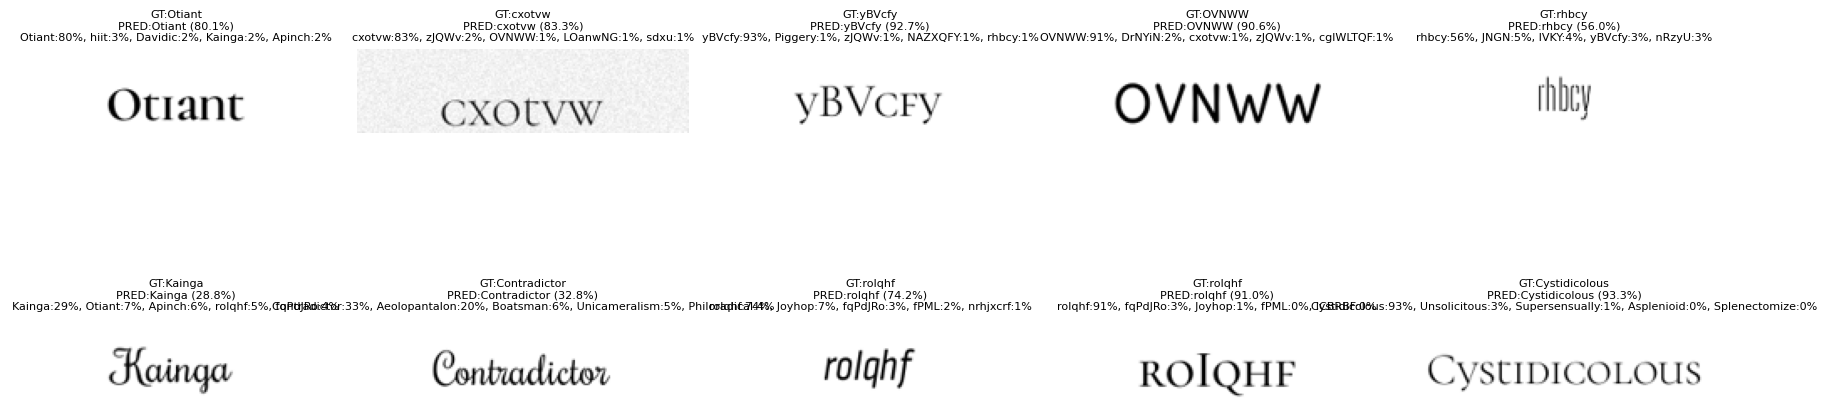

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import random

# helper: topk prediction
def predict_topk_tensor(x_tensor, topk=5):
    model.eval()
    with torch.no_grad():
        logits = model(x_tensor.to(device))
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    top_idx = probs.argsort()[-topk:][::-1]
    # mapped indices to labels
    return [(classes[i], float(probs[i])) for i in top_idx]

def show_grid(paths, rows=2, cols=5, topk=5):
    n = min(len(paths), rows*cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3.5))
    axs = axs.flatten()
    for ax, (p, gt) in zip(axs, paths[:n]):
        img = Image.open(p).convert("L").resize((IMG_W, IMG_H))
        x = np.asarray(img, np.float32)/255.0

        mean = float(locals().get("train_mean", 0.5))
        std  = float(locals().get("train_std", 0.25))
        x_n = (x - mean) / (std + 1e-8)

        # as predict_topk expects (1,1,H,W):-
        x_t = torch.tensor(np.expand_dims(np.expand_dims(x_n, 0), 0), dtype=torch.float32)

        top5 = predict_topk_tensor(x_t, topk=topk)
        pred, pprob = top5[0]

        ax.imshow(img, cmap='gray')
        ax.axis('off')
        title = f"GT:{gt}\nPRED:{pred} ({pprob*100:.1f}%)\n" + ", ".join([f"{lab}:{prob*100:.0f}%" for lab,prob in top5])
        ax.set_title(title, fontsize=8)

    for ax in axs[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# print 10 examples
samples = random.sample(split_items["test"], k=min(10, len(split_items["test"])))
show_grid(samples, rows=2, cols=5, topk=5)


In [16]:
#generation task
#generating 20k images (10k was less, wasnt converging)

import os, csv, random, re, json
import nltk

OUT = Path("/content/ocr_20k_fixed")
MERGE_LOCK = OUT / "_generated.lock"
FONT_DIR = Path("/content/Captcha_codebase/fonts")
TOTAL_IMAGES = 20000
HARD_PCT = 0.25
IMG_SIZE = (198, 50)
IMG_CANVAS = (256, 64)
TRAIN_PCT, VAL_PCT, TEST_PCT = 0.8, 0.1, 0.1
SEED = 42
MIN_WORD_LEN = 3
MAX_WORD_LEN = 12
ENGLISH_WORD_PCT = 0.6              # % of valid english words taken

random.seed(SEED)
np.random.seed(SEED)
#checks (gemini suggested)
OUT.mkdir(parents=True, exist_ok=True)
for s in ("train","val","test"):
    (OUT/s).mkdir(exist_ok=True)

font_files = [str(FONT_DIR/f) for f in os.listdir(FONT_DIR) if f.lower().endswith(".ttf")]
if not font_files:
    raise RuntimeError(f"No .ttf fonts found in {FONT_DIR}. Clone fonts into repo or change FONT_DIR.")
print(f"Found {len(font_files)} fonts")

#fixing a prior error..ignore
if MERGE_LOCK.exists():
    print("Dataset already generated (lockfile present). Re-using:", OUT)
else:
    print("Generating dataset into:", OUT)
#using nltk
    try:
        from nltk.corpus import words as nltk_words
    except Exception:
        nltk.download("words")
        from nltk.corpus import words as nltk_words

    english_words = [w for w in nltk_words.words() if w.isalpha() and MIN_WORD_LEN <= len(w) <= MAX_WORD_LEN]
#filter to mixed-case variations for later training
    english_words = list(set(english_words))
    random.shuffle(english_words)
    print("English words available:", len(english_words))

#synthesisng random alpha string
    import string
    def random_word(min_len=MIN_WORD_LEN, max_len=MAX_WORD_LEN):
        L = random.randint(min_len, max_len)
        return "".join(random.choice(string.ascii_letters) for _ in range(L))

#assemble target word list (we need enough distinct words)
#target unique words:TOTAL_IMAGES // 4 unique words (so ~5 variants each on average)-gemini, earlier tested words were 10 variants of the same word, so had to change
    target_unique_words = max(500, TOTAL_IMAGES // 8)
    word_pool = []

#mix english and syntehtic words
    n_english = int(target_unique_words * ENGLISH_WORD_PCT)
    n_synth   = target_unique_words - n_english
#english words
    word_pool += [w for w in english_words[:n_english]]

#random syntehtic-word strings
    while len(word_pool) < target_unique_words:
        w = random_word(MIN_WORD_LEN, MAX_WORD_LEN)
        if w not in word_pool:
            word_pool.append(w)

    random.shuffle(word_pool)
    print("Target unique words:", len(word_pool))

#helpers
    def add_noise(img, nl=18):
        arr = np.array(img)
        noise = np.random.randint(-nl, nl, arr.shape, dtype=np.int16)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

    def render_clean(word):
        font_file = random.choice(font_files)
        font_size = random.randint(30, 40)
        font = ImageFont.truetype(font_file, font_size)
        bg = (255,255,255)
        img = Image.new("RGB", IMG_CANVAS, bg)
        draw = ImageDraw.Draw(img)
        text = word #no spaces
        bbox = draw.textbbox((0,0), text, font=font)
        tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x = (IMG_CANVAS[0] - tw)//2
        y = (IMG_CANVAS[1] - th)//2
        draw.text((x,y), text, font=font, fill=(0,0,0))
#adding lil jitter now
        if random.random() < 0.05:
            img = img.rotate(random.uniform(-1.0,1.0), expand=True, fillcolor=bg).resize(IMG_CANVAS)
        return img.resize(IMG_SIZE)

    def render_hard(word):
        font_file = random.choice(font_files)
        font_size = random.randint(26, 40)
        try:
            font = ImageFont.truetype(font_file, font_size)
        except:
            font = ImageFont.load_default()
        bg_color = tuple(random.randint(200,255) for _ in range(3))
        img = Image.new("RGB", IMG_CANVAS, bg_color)
        draw = ImageDraw.Draw(img)

#toggle case now, but word is preserved
        case = random.choice(["as_is","upper","lower","capitalize","toggle"])
        if case == "upper":
            text = word.upper()
        elif case == "lower":
            text = word.lower()
        elif case == "capitalize":
            text = word.capitalize()
        elif case == "toggle":
            text = "".join(ch.swapcase() for ch in word)
        else:
            text = word

        bbox = draw.textbbox((0,0), text, font=font)
        tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x = (IMG_CANVAS[0] - tw)//2 + random.randint(-6,6)
        y = (IMG_CANVAS[1] - th)//2 + random.randint(-3,3)
        text_color = (random.randint(0,80), random.randint(0,80), random.randint(0,80))
        draw.text((x,y), text, font=font, fill=text_color)

        if random.random() < 0.55:
            img = img.rotate(random.uniform(-6,6), expand=True, fillcolor=bg_color).resize(IMG_CANVAS)
        if random.random() < 0.45:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2,1.2)))
        if random.random() < 0.65:
            img = add_noise(img, nl=18)
        return img.resize(IMG_SIZE)

    all_entries = []  # tuples (relpath,label)
    cnt = 0
#strategy:iterate over the word_pool and synthesise variants until TOTAL_IMAGES hit
    wp_idx = 0
    while cnt < TOTAL_IMAGES:
        word = word_pool[wp_idx % len(word_pool)]
        wp_idx += 1

#no. of variants for this base word
        variants = random.randint(1, 6)  #synthesising between 1 and 6 variants per loop; helps distribution
        for v in range(variants):
            if cnt >= TOTAL_IMAGES: break
#deciding clean or hard
            is_hard = random.random() < HARD_PCT
            fname = f"{re.sub(r'[^A-Za-z0-9]','',word)}_{cnt:06d}.png"
            split_roll = random.random()
            if split_roll < TRAIN_PCT:
                split = "train"
            elif split_roll < TRAIN_PCT + VAL_PCT:
                split = "val"
            else:
                split = "test"
            rel = f"{split}/{fname}"
            outpath = OUT / rel

            (OUT/split).mkdir(parents=True, exist_ok=True)

            try:
                img = render_hard(word) if is_hard else render_clean(word)
                img.save(outpath)
                all_entries.append((rel, word))
                cnt += 1
            except Exception as e:
                print("Render failed for", word, e)


#labels
    with open(OUT/"labels.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(all_entries)

#lockfile etc
    cfg = dict(total_images=TOTAL_IMAGES, hard_pct=HARD_PCT, img_size=IMG_SIZE, seed=SEED,
               unique_words=len(word_pool), word_pool_sample=word_pool[:50])
    with open(OUT/"config.json", "w") as cf:
        json.dump(cfg, cf, indent=2)
    MERGE_LOCK.write_text("done")
    print("Generated", cnt, "images into", OUT)
    print("Config saved to", OUT/"config.json")

Found 15 fonts
Generating dataset into: /content/ocr_20k_fixed
English words available: 198247
Target unique words: 2500
Generated 20000 images into /content/ocr_20k_fixed
Config saved to /content/ocr_20k_fixed/config.json


Total rows: 20000
path
train    16002
test      2027
val       1971
Name: count, dtype: int64


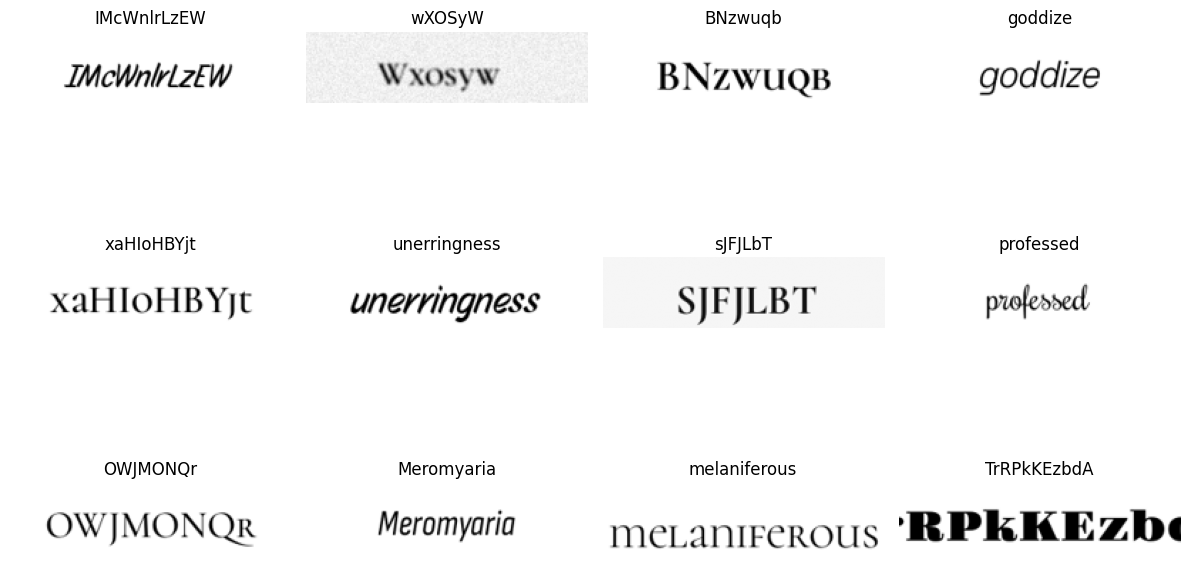

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# load csv
df = pd.read_csv("/content/ocr_20k_fixed/labels.csv", names=["path","label"])
print("Total rows:", len(df))
print(df["path"].str.split("/").str[0].value_counts())

# sanity check
samples = df.sample(12, random_state=1).reset_index(drop=True)
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for ax, (_, row) in zip(axes.flatten(), samples.iterrows()):
    img = Image.open("/content/ocr_20k_fixed/" + row['path'])
    ax.imshow(img.convert("L"), cmap='gray')
    ax.axis('off')
    ax.set_title(row['label'])
plt.tight_layout()
plt.show()


In [20]:

#CRNN on 20k dataset - better config
import time
from torch.utils.data import Dataset, DataLoader


ROOT = Path("/content/ocr_20k_fixed")
IMG_HEIGHT = 48
MAX_WIDTH = 1600
BATCH = 16
EPOCHS = 60
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



#fetching labels etc
labels = []
with open(ROOT/"labels.csv") as f:
    for row in csv.reader(f):
        if row: labels.append(row[1])
chars = sorted(set("".join(labels)))
char_to_idx = {c:i+1 for i,c in enumerate(chars)}
idx_to_char = {i+1:c for i,c in enumerate(chars)}
blank_idx = 0
num_classes = len(chars) + 1
print("Alphabet size:", len(chars), "num_classes:", num_classes)
#dataset
class OCRDataset(Dataset):
    def __init__(self, root, split="train", img_h=IMG_HEIGHT, max_w=MAX_WIDTH):
        self.root = Path(root)
        self.img_h = img_h
        self.max_w = max_w
        self.items = []
        with open(self.root/"labels.csv") as f:
            for p, lab in csv.reader(f):
                if p.startswith(split + "/"):
                    self.items.append((self.root/p, lab))
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        p, lab = self.items[idx]
        img = Image.open(p).convert("L")
        w, h = img.size
        new_w = max(1, int(w * (self.img_h / float(h))))
        new_w = min(new_w, self.max_w)
        img = img.resize((new_w, self.img_h), Image.BILINEAR)
        arr = np.asarray(img, np.float32)/255.0
        arr = (arr - 0.5)/0.5
        return arr, lab, new_w

def encode_label(s): return [char_to_idx[c] for c in s]

def collate_fn(batch):
    imgs, labs, widths = zip(*batch)
    max_w = max(widths)
    x = np.zeros((len(imgs),1,IMG_HEIGHT,max_w), np.float32)
    for i,arr in enumerate(imgs): x[i,0,:arr.shape[0],:arr.shape[1]] = arr
    targets, target_lengths = [], []
    for lab in labs:
        enc = encode_label(lab)
        targets.extend(enc)
        target_lengths.append(len(enc))
    return (torch.tensor(x),
            torch.tensor(targets,dtype=torch.long),
            torch.tensor(target_lengths,dtype=torch.long),
            torch.tensor(widths,dtype=torch.long),
            list(labs))

#crnn arch
class CRNN(nn.Module):
    def __init__(self, num_classes, img_h=IMG_HEIGHT):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,1,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256,256,3,1,1), nn.ReLU(), nn.MaxPool2d((2,1),(2,1)),
            nn.Conv2d(256,512,3,1,1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512,512,3,1,1), nn.ReLU(), nn.MaxPool2d((2,1),(2,1)),
        )
        self.rnn_in = 512*(img_h//16)
        self.lstm1 = nn.LSTM(self.rnn_in, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)
    def forward(self,x):
        feat = self.cnn(x)   # (B,C,H,W)
        feat = feat.permute(0,3,1,2).contiguous()
        B,T,C,H = feat.size()
        feat = feat.view(B,T,C*H)
        out,_ = self.lstm1(feat)
        out,_ = self.lstm2(out)
        return self.fc(out)

#helpers
def greedy_decode(probs):
    seq = probs.argmax(1)
    s,prev=[],-1
    for idx in seq:
        if idx!=prev and idx!=blank_idx:
            s.append(idx_to_char[idx.item()])
        prev=idx
    return "".join(s)

def compute_input_lengths(widths,factor=4): return [max(1,w//factor) for w in widths]

def edit_distance(a,b):
    dp=range(len(b)+1)
    for i,ca in enumerate(a,1):
        new=[i]
        for j,cb in enumerate(b,1):
            cost=0 if ca==cb else 1
            new.append(min(dp[j]+1,new[-1]+1,dp[j-1]+cost))
        dp=new
    return dp[-1]

def evaluate(loader):
    model.eval(); total_cer=0;total_chars=0;correct=0;total=0;ex=[]
    with torch.no_grad():
        for x,t,tl,widths,labs in loader:
            x=x.to(DEVICE)
            probs=F.softmax(model(x),2).cpu()
            for i in range(len(labs)):
                pred=greedy_decode(probs[i])
                gt=labs[i]
                total_cer+=edit_distance(pred,gt)
                total_chars+=len(gt)
                if pred==gt: correct+=1
                total+=1
                if len(ex)<10: ex.append((pred,gt))
    return total_cer/max(1,total_chars), correct/max(1,total), ex

#training
train_loader=DataLoader(OCRDataset(ROOT, "train"),batch_size=BATCH,shuffle=True,collate_fn=collate_fn)
val_loader  =DataLoader(OCRDataset(ROOT, "val"),batch_size=BATCH,shuffle=False,collate_fn=collate_fn)
test_loader =DataLoader(OCRDataset(ROOT, "test"),batch_size=BATCH,shuffle=False,collate_fn=collate_fn)

model=CRNN(num_classes).to(DEVICE)
criterion=nn.CTCLoss(blank=blank_idx,zero_infinity=True)
opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=1e-5)
sched=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=LR,steps_per_epoch=len(train_loader),epochs=EPOCHS)

best_cer=1e9;best_state=None
for ep in range(1,EPOCHS+1):
    model.train();tot=0;n=0
    for x,t,tl,widths,labs in train_loader:
        x,t,tl=x.to(DEVICE),t.to(DEVICE),tl.to(DEVICE)
        logit=model(x)
        logp=F.log_softmax(logit,2).permute(1,0,2)
        inp_len=torch.tensor(compute_input_lengths(widths),dtype=torch.long)
        loss=criterion(logp,t,inp_len,tl)
        opt.zero_grad();loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),5.0)
        opt.step();sched.step()
        tot+=loss.item()*x.size(0);n+=x.size(0)
    val_cer,val_acc,samp=evaluate(val_loader)
    print(f"Epoch {ep:02d} | Loss {tot/n:.3f} | Val CER {val_cer*100:.2f}% | Val WordAcc {val_acc*100:.2f}%")
    if val_cer<best_cer:
        best_cer=val_cer;best_state=model.state_dict()
        torch.save(best_state,"crnn20k_best.pth")

#testing now
model.load_state_dict(torch.load("crnn20k_best.pth"))
test_cer,test_acc,ex=evaluate(test_loader)
print(f"TEST CER {test_cer*100:.2f}% | WordAcc {test_acc*100:.2f}%")
print("Examples:",ex)

Alphabet size: 52 num_classes: 53
Epoch 01 | Loss 4.104 | Val CER 100.00% | Val WordAcc 0.00%
Epoch 02 | Loss 3.237 | Val CER 72.93% | Val WordAcc 0.10%
Epoch 03 | Loss 1.166 | Val CER 15.38% | Val WordAcc 55.61%
Epoch 04 | Loss 0.447 | Val CER 14.66% | Val WordAcc 58.24%
Epoch 05 | Loss 0.331 | Val CER 11.29% | Val WordAcc 64.69%
Epoch 06 | Loss 0.286 | Val CER 13.36% | Val WordAcc 57.43%
Epoch 07 | Loss 0.264 | Val CER 10.67% | Val WordAcc 68.29%
Epoch 08 | Loss 0.241 | Val CER 11.16% | Val WordAcc 65.50%
Epoch 09 | Loss 0.230 | Val CER 9.92% | Val WordAcc 69.66%
Epoch 10 | Loss 0.223 | Val CER 10.15% | Val WordAcc 68.24%
Epoch 11 | Loss 0.213 | Val CER 12.29% | Val WordAcc 59.06%
Epoch 12 | Loss 0.191 | Val CER 9.02% | Val WordAcc 69.66%
Epoch 13 | Loss 0.182 | Val CER 8.58% | Val WordAcc 70.22%
Epoch 14 | Loss 0.165 | Val CER 9.36% | Val WordAcc 66.01%
Epoch 15 | Loss 0.149 | Val CER 8.55% | Val WordAcc 70.67%
Epoch 16 | Loss 0.145 | Val CER 11.95% | Val WordAcc 56.11%
Epoch 17 | L

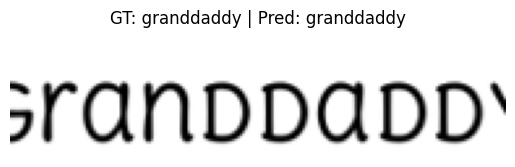

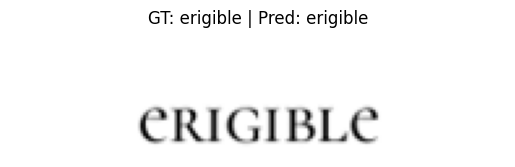

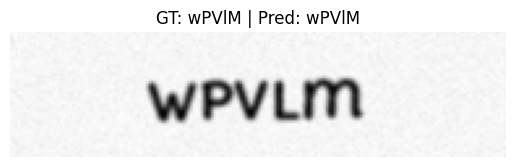

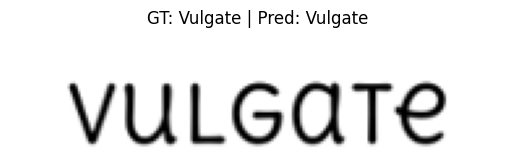

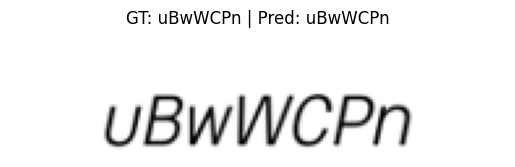

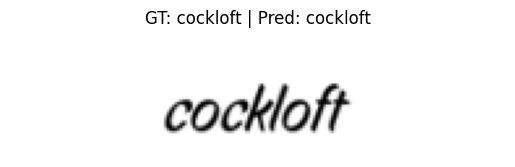

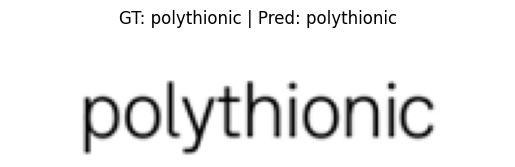

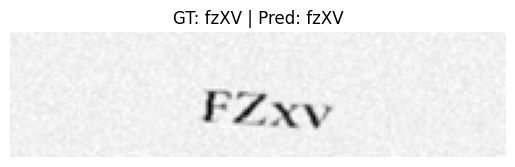

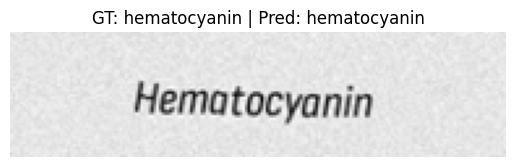

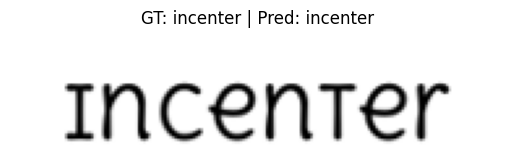

In [21]:

#10 randomised samples for eval
samples = random.sample(test_loader.dataset.items, 10)

model.eval()
for path, gt in samples:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, np.float32)/255.0
    arr = (arr - 0.5)/0.5
    h = IMG_HEIGHT
    new_w = int(img.width * (h / img.height))
    img_resized = img.resize((new_w, h))
    arr = np.asarray(img_resized, np.float32)/255.0
    arr = (arr - 0.5)/0.5
    x = torch.tensor(arr[np.newaxis, np.newaxis], dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        logits = model(x)                  # (1, T, C)
        probs = F.softmax(logits, dim=2).squeeze(0).cpu().numpy()
    pred = greedy_decode(probs)

    plt.imshow(img_resized, cmap="gray")
    plt.title(f"GT: {gt} | Pred: {pred}")
    plt.axis("off")
    plt.show()

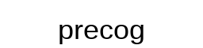

GT: precog Pred: precog


In [22]:
#testing generalisability (entered word isnt in its dataset)
from PIL import ImageDraw, ImageFont
word = "precog"
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 36)
canvas=(256,64); bg=(255,255,255)
img=Image.new("RGB", canvas, bg); draw=ImageDraw.Draw(img)
bbox=draw.textbbox((0,0), word, font=font)
x=(canvas[0]- (bbox[2]-bbox[0]))//2; y=(canvas[1]-(bbox[3]-bbox[1]))//2
draw.text((x,y), word, font=font, fill=(0,0,0))
img_resized = img.resize((int((bbox[2]-bbox[0])*(IMG_HEIGHT/(bbox[3]-bbox[1]))), IMG_HEIGHT)).convert("L")
display(img_resized)
#prediction
arr = (np.asarray(img_resized, np.float32)/255.0 - 0.5)/0.5
x = torch.tensor(arr[np.newaxis, np.newaxis], dtype=torch.float32).to(DEVICE)
with torch.no_grad():
    probs = F.softmax(model(x), dim=2).squeeze(0).cpu().numpy()
pred = greedy_decode(probs)
print("GT:", word, "Pred:", pred)

In [23]:
#saving cnn
cnn_model_path = "cnn_model.pth"
torch.save(model.state_dict(), cnn_model_path)
print(f"CNN model saved to {cnn_model_path}")

#saving crnn
crnn_model_path = "crnn_model.pth"
torch.save(model.state_dict(), crnn_model_path)
print(f"CRNN model saved to {crnn_model_path}")

CNN model saved to cnn_model.pth
CRNN model saved to crnn_model.pth
